In [1]:
is_skip = True

# Data params
desired_batch_size = 128
batch_size = 16
# batch_size = 4
grad_accm_step_max = desired_batch_size // batch_size
print(grad_accm_step_max)

# Model params
d_model = 128
nhead = 2
d_ff = 256
dropout = 0.1
num_layers = 2
num_remain_tokens = 0.3
num_remain_tokens_for_cat = 0.7

patch_size = 8  # 14

8


# Import

In [2]:
import os
import joblib
import copy
import time
import math

from tqdm import tqdm
from IPython.display import clear_output
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

import torch
from transformers import BertConfig, BertTokenizer, BertModel
from pytorch_model_summary import summary

from PIL import Image
from torchvision import transforms
import cv2
from transformers import ViTImageProcessor, MobileViTModel, MobileViTConfig, ViTModel, AutoImageProcessor, ViTConfig, BertModel, BertTokenizer, DistilBertModel, DistilBertTokenizer, Dinov2Config, Dinov2Model
from skimage import io

device = torch.device("cuda")
# device = torch.device("cpu")
tqdm.pandas()

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

### Read

In [3]:
if not is_skip:
    us_holiday = holidays.US()
    
    # Read transaction
    df_trans = pd.read_csv("../HnM/transactions_train.csv", parse_dates=["t_dat"], dtype={"article_id":str})
    df_meta = pd.read_csv("../HnM/articles.csv", dtype={"article_id":str})

    min_year = df_trans["t_dat"].dt.year.min()
    max_year = df_trans["t_dat"].dt.year.max()

    holiday = holidays.US(years=(min_year, max_year))
    holiday = pd.DataFrame({"t_dat":holiday.keys(), "holiday":holiday.values()})
    holiday["t_dat"] = pd.to_datetime(holiday["t_dat"])

In [4]:
def preprocess(data):
    data = data.copy()

    # Image path
    data["img_path"] = data["article_id"].apply(lambda x: f'../HnM/resized_images/{x[:3]}/{x}.jpg')
    data["is_valid"] = data["img_path"].apply(lambda x: 1 if os.path.isfile(x) else 0) # Check whether the article has corresponding image file
    data = data[data["is_valid"] == 1].drop("is_valid", axis=1) # Valid if having corresponding image

    # Make sales
    data = data.groupby(["t_dat", "article_id", "img_path"], as_index=False).agg(sales=("customer_id", "count"), price=("price", "mean"))
    data["size"] = data.groupby(["article_id"], as_index=False)["sales"].transform("count")
    data = data[(data["size"]>=100)]

    # Expand dates
    data = data.set_index("t_dat").groupby(["article_id"], as_index=False).resample("1D").asfreq().reset_index()
    data["sales"] = data["sales"].fillna(0)
    data["price"] = data["price"].fillna(method="ffill")
    data["article_id"] = data["article_id"].fillna(method="ffill")
    data["img_path"] = data["img_path"].fillna(method="ffill")
    data = data.sort_values(["article_id", "t_dat"])
    
    data["size"] = data.groupby(["article_id"], as_index=False)["sales"].transform("count")
    data["time_idx"] = data.groupby("article_id").cumcount()
    data["time_idx"] = data["size"] - data["time_idx"]

    # Make holidays
    data = pd.merge(data, holiday, on="t_dat", how="left")
    display(data)

    # Temporal information
    # Make sure the sequence start from 0
    data["day"] = data["t_dat"].dt.day - 1
    data["dow"] = data["t_dat"].dt.dayofweek
    data["month"] = data["t_dat"].dt.month - 1
    data["year"] = data["t_dat"].dt.year / (data["t_dat"].dt.year.max() + 1)

    # Append meta data
    # data = data.merge(df_meta[["index_name", "article_id", "colour_group_name", "graphical_appearance_name", "product_type_name"]], on="article_id")
    data = data.merge(df_meta[["index_name", "article_id", "colour_group_name", "graphical_appearance_name", "prod_name"]], on="article_id")
    data = data.rename(columns={"index_name":"index", "colour_group_name":"color", "graphical_appearance_name":"graphic", "prod_name":"prod"})

    # Output
    return data.reset_index(drop=True)

if not is_skip:
    df_prep = df_trans.copy()#.iloc[:1000]
    data = preprocess(df_prep)
    
    data.to_parquet("data.pq")

### Dataset

In [5]:
class LogScaler(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        self.a = 1
        return self
    
    def transform(self, x, y=None):
        return np.log1p(x)
    
    def inverse_transform(self, x, y=None):
        return np.expm1(x)
    
class NoneScaler(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        x = x.copy()
        return x
    
    def inverse_transform(self, x, y=None):
        x = x.copy()
        return x

class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mapper = {}
        self.idx = 0

    def fit(self, x, y=None):
        x = set(x)
        for val in x:
            if val not in self.mapper.keys():
                self.mapper[val] = self.idx
                self.idx += 1
        self.mapper["unseen"] = self.idx
        return self
    
    def transform(self, x, y=None):
        res = []
        for val in x:
            if val in self.mapper.keys():
                res.append(self.mapper[val])
            else:
                res.append(self.idx)
        return np.array(res)
    
    def inverse_transform(self, idx):
        inverse_mapper = {val:key for key, val in self.mapper.items()}
        return inverse_mapper[idx]

# 1==1

In [6]:
class DynamicVars():
    def set(self, name, var):
        self.__dict__[name] = var

d = DynamicVars()
d.set("a", 1)

d.a
# 1==1

1

In [7]:
data = pd.read_parquet("data.pq")
df_train = data[data["time_idx"]<=365]
df_valid = data[data["time_idx"]<=365+90]

# df_train = df_train[df_train["index_name"] == "Ladieswear"]
# df_valid = df_valid[df_valid["index_name"] == "Ladieswear"]

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, d_model, is_train=True, label_encoder_dict=None):
        # Define parameters
        d = DynamicVars()
        assert label_encoder_dict is None if is_train else not None # In test mode, label_encoder_dict should be provided
        self.is_train, self.label_encoder_dict, self.d_model = is_train, label_encoder_dict, d_model
        self.cat_cols = ["holiday", "index", "color", "graphic", "prod"]
        # self.transform = transforms.Compose([
        #     transforms.Resize((224,224)),
        #     transforms.ToTensor(),
        #     # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        # ])
        self.transform = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

        # Label encode categorical variables
        if self.is_train:
            for cat in self.cat_cols:
                self.__dict__[f"{cat}_encoder"] = CustomLabelEncoder()
                self.__dict__[f"{cat}_encoder"].fit(data[cat])
        else: 
            for cat in self.cat_cols:
                self.__dict__[f"{cat}_encoder"] = label_encoder_dict[f"{cat}_encoder"]
            
        # Iterate each product
        self.data_li = []
        self.min_val, self.max_val = data["sales"].min(), data["sales"].max()
        data.groupby("article_id").progress_apply(lambda x: self.data_li.append(x))
    
    def get_encoder_dict(self):
        return {f"{col}_encoder":self.__dict__[f"{col}_encoder"] for col in self.cat_cols}

    def __len__(self):
        return len(self.data_li)
    
    def __getitem__(self, idx):
        # Obtain information about data for each
        data = self.data_li[idx]
        
        # Label encode
        for col in self.cat_cols:
            data[col] = self.__dict__[f"{col}_encoder"].transform(data[col])

        # Name each and scale data ----------------------------------------------------------------------------------
        sales_scaler, price_scaler = LogScaler(), NoneScaler()
        # sales_scaler, price_scaler = StandardScaler(), NoneScaler()
        
        ## Sales information
        sales = sales_scaler.fit_transform(data["sales"].values.reshape(-1,1)).reshape(-1)
        ## Temporal information
        day = data["day"].values
        dow = data["dow"].values
        month = data["month"].values
        holiday = data["holiday"].values
        price = price_scaler.fit_transform(data["price"].values.reshape(-1,1)).reshape(-1)
        ## Static information
        index = data["index"].values[[0]]
        color = data["color"].values[[0]]
        graphic = data["graphic"].values[[0]]
        prod = data["prod"].values[[0]]
        img_path = data["img_path"].values[0]
        img_raw = Image.open(img_path).convert("RGB")
        img_input = self.transform(img_raw, return_tensors="pt", train=False)["pixel_values"].squeeze(0)
        # img_input = self.transform(img_raw).squeeze()

        # Generate mask
        if self.is_train:
            for data in ["sales", "day", "dow", "month", "holiday", "price"]:
                locals()[f"{data}_idx_keep"], locals()[f"{data}_revert"], locals()[f"{data}_keep_padding_mask"], locals()[f"{data}_revert_padding_mask"] = self.generate_mask(locals()[data])
        else:
            for data in ["sales", "day", "dow", "month", "holiday", "price"]:
                locals()[f"{data}_idx_keep"], locals()[f"{data}_revert"], locals()[f"{data}_keep_padding_mask"], locals()[f"{data}_revert_padding_mask"] = self.generate_valid_mask(locals()[data])
        
        # Finalize
        for data in ["sales", "day", "dow", "month", "holiday", "price"]:
            assert (locals()[f"sales_keep_padding_mask"] == locals()[f"{data}_keep_padding_mask"]).all()
            assert (locals()[f"sales_revert_padding_mask"] == locals()[f"{data}_revert_padding_mask"]).all()
        

        return {"sales": torch.Tensor(sales), 
                "day":torch.IntTensor(day), "dow":torch.IntTensor(dow), "month":torch.IntTensor(month), "holiday":torch.IntTensor(holiday), "price":torch.Tensor(price),
                "index": torch.IntTensor(index), "color": torch.IntTensor(color), "graphic": torch.IntTensor(graphic), "prod": torch.IntTensor(prod), 
                "img_raw":img_raw, "img_input": img_input,
                "sales_idx_keep":locals()["sales_idx_keep"], "sales_revert":locals()["sales_revert"],
                "day_idx_keep":locals()["day_idx_keep"], "day_revert":locals()["day_revert"],
                "dow_idx_keep":locals()["dow_idx_keep"], "dow_revert":locals()["dow_revert"],
                "month_idx_keep":locals()["month_idx_keep"], "month_revert":locals()["month_revert"],
                "holiday_idx_keep":locals()["holiday_idx_keep"], "holiday_revert":locals()["holiday_revert"],
                "price_idx_keep":locals()["price_idx_keep"], "price_revert":locals()["price_revert"],
                "temp_keep_padding_mask":locals()["sales_keep_padding_mask"], "temp_revert_padding_mask":locals()["sales_revert_padding_mask"]}

    def generate_mask(self, data):
        num_keeps = int(len(data) * num_remain_tokens)
        
        # Index for shuffle and revert
        noise = torch.rand(data.shape)
        shuffle = torch.argsort(noise, dim=0)
        revert = torch.argsort(shuffle, dim=0)
        
        idx_keep = shuffle[:num_keeps]
        idx_masked = shuffle[num_keeps:]

        keep_padding_mask = torch.zeros(idx_keep.shape)
        revert_padding_mask = torch.zeros(revert.shape)
        return idx_keep, revert, keep_padding_mask, revert_padding_mask

    def generate_valid_mask(self, data, skip=False):
        idx = torch.arange(data.shape[0])
        revert = torch.argsort(idx)
        idx_keep = idx[:-90]
        idx_masked = idx[-90:]
        
        keep_padding_mask = torch.zeros(idx_keep.shape)
        revert_padding_mask = torch.zeros(revert.shape)

        return idx_keep, revert, keep_padding_mask, revert_padding_mask

def collate_fn(batch_li):
    # Get data
    for data in ["sales", "day", "dow", "month", "holiday", "index", "color", "graphic", "prod", "price", "img_raw", "img_input"]:
        locals()[data] = [batch[data] for batch in batch_li]

    for data in ["sales_idx_keep", "sales_revert",
                "day_idx_keep", "day_revert",
                "dow_idx_keep", "dow_revert",
                "month_idx_keep", "month_revert",
                "holiday_idx_keep", "holiday_revert",
                "price_idx_keep", "price_revert",
                "temp_keep_padding_mask", "temp_revert_padding_mask"]:
        locals()[data] = [batch[data] for batch in batch_li]

    locals()["img_input"] = torch.stack(locals()["img_input"])

    # Pad data
    for data in ["sales", "day", "dow", "month", "holiday", "price",
                 "sales_idx_keep", "sales_revert",
                "day_idx_keep", "day_revert",
                "dow_idx_keep", "dow_revert",
                "month_idx_keep", "month_revert",
                "holiday_idx_keep", "holiday_revert",
                "price_idx_keep", "price_revert",
                "temp_keep_padding_mask", "temp_revert_padding_mask"]:
        if "padding_mask" in data: # Incoming padding_mask is basically all 0
            padding_value = 1
        elif "idx_keep" in data or "revert" in data: # In order to sort paddings to the last
            padding_value = locals()["sales"].shape[-1]-1
        else: padding_value = 0
        locals()[data] = torch.nn.utils.rnn.pad_sequence(locals()[data], batch_first=True, padding_value=padding_value)
    
    return {"sales": locals()["sales"], 
            "day":locals()["day"], "dow":locals()["dow"], "month":locals()["month"], "holiday":locals()["holiday"], "price":locals()["price"], 
            "index": torch.stack(locals()["index"]), "color": torch.stack(locals()["color"]), "graphic": torch.stack(locals()["graphic"]), "prod": torch.stack(locals()["prod"]),
            "img_raw": locals()["img_raw"], "img_input":locals()["img_input"],
            "sales_idx_keep":locals()["sales_idx_keep"], "sales_revert":locals()["sales_revert"],
            "day_idx_keep":locals()["day_idx_keep"], "day_revert":locals()["day_revert"],
            "dow_idx_keep":locals()["dow_idx_keep"], "dow_revert":locals()["dow_revert"],
            "month_idx_keep":locals()["month_idx_keep"], "month_revert":locals()["month_revert"],
            "holiday_idx_keep":locals()["holiday_idx_keep"], "holiday_revert":locals()["holiday_revert"],
            "price_idx_keep":locals()["price_idx_keep"], "price_revert":locals()["price_revert"],
            "temp_keep_padding_mask":locals()["temp_keep_padding_mask"], "temp_revert_padding_mask":locals()["temp_revert_padding_mask"]}

train_dataset = Dataset(df_train, d_model)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=16)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

valid_dataset = Dataset(df_valid, d_model, is_train=False, label_encoder_dict=train_dataset.get_encoder_dict())
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=16)
# valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

for data in train_dataloader:
    print("sales:", data["sales"].shape)
    print("img_input", data["img_input"].shape)
    print("sales_idx_keep:", data["sales_idx_keep"].shape)
    print("sales_revert:", data["sales_revert"].shape)
    print("temp_keep_padding_mask:", data["temp_keep_padding_mask"].shape)
    print("temp_revert_padding_mask:", data["temp_revert_padding_mask"].shape)
    break

100%|██████████| 26842/26842 [00:01<00:00, 26762.40it/s]


sales: torch.Size([16, 365])
img_input torch.Size([16, 3, 224, 224])
sales_idx_keep: torch.Size([16, 109])
sales_revert: torch.Size([16, 365])
temp_keep_padding_mask: torch.Size([16, 109])
temp_revert_padding_mask: torch.Size([16, 365])


In [8]:
for valid_data in valid_dataloader:
    print("sales:", valid_data["sales"].shape)
    print("img_input", valid_data["img_input"].shape)
    print("sales_idx_keep:", valid_data["sales_idx_keep"].shape)
    print("sales_revert:", valid_data["sales_revert"].shape)
    print("temp_keep_padding_mask:", valid_data["temp_keep_padding_mask"].shape)
    print("temp_revert_padding_mask:", valid_data["temp_revert_padding_mask"].shape)
    break

sales: torch.Size([16, 455])
img_input torch.Size([16, 3, 224, 224])
sales_idx_keep: torch.Size([16, 365])
sales_revert: torch.Size([16, 455])
temp_keep_padding_mask: torch.Size([16, 365])
temp_revert_padding_mask: torch.Size([16, 455])


# Architecture

### Helper

In [9]:
from torch.nn import functional as F

def _generate_square_subsequent_mask(sz, device, dtype):
    return torch.triu(
        torch.full((sz, sz), float('-inf'), dtype=dtype, device=device),
        diagonal=1,
    )

def _get_seq_len(src, batch_first):
    if src.is_nested:
        return None
    else:
        src_size = src.size()
        if len(src_size) == 2:
            # unbatched: S, E
            return src_size[0]
        else:
            # batched: B, S, E if batch_first else S, B, E
            seq_len_pos = 1 if batch_first else 0
            return src_size[seq_len_pos]

def _detect_is_causal_mask(mask, is_causal=None,size=None):
    # Prevent type refinement
    make_causal = (is_causal is True)

    if is_causal is None and mask is not None:
        sz = size if size is not None else mask.size(-2)
        causal_comparison = _generate_square_subsequent_mask(
            sz, device=mask.device, dtype=mask.dtype)

        # Do not use `torch.equal` so we handle batched masks by
        # broadcasting the comparison.
        if mask.size() == causal_comparison.size():
            make_causal = bool((mask == causal_comparison).all())
        else:
            make_causal = False

    return make_causal

class EncoderLayer(torch.nn.TransformerEncoderLayer):
    def forward(self, src, pos_enc, src_mask=None, src_key_padding_mask=None, is_causal=False):
        x = src
        attn_output, attn_weight = self._sa_block(x, pos_enc, src_mask, src_key_padding_mask, is_causal=is_causal)
        x = self.norm1(x + attn_output)
        x = self.norm2(x + self._ff_block(x))

        return x, attn_weight

    # self-attention block
    def _sa_block(self, x, pos_enc, attn_mask, key_padding_mask, is_causal=False):
        x, attn_weight = self.self_attn(x+pos_enc, x+pos_enc, x,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           need_weights=True, is_causal=is_causal, average_attn_weights=False)
        return self.dropout1(x), attn_weight

class Encoder(torch.nn.TransformerEncoder):
    def forward(self, src, pos_enc=0, mask=None, src_key_padding_mask=None, is_causal=None):
       ################################################################################################################
        src_key_padding_mask = F._canonical_mask(
            mask=src_key_padding_mask,
            mask_name="src_key_padding_mask",
            other_type=F._none_or_dtype(mask),
            other_name="mask",
            target_type=src.dtype
        )

        mask = F._canonical_mask(
            mask=mask,
            mask_name="mask",
            other_type=None,
            other_name="",
            target_type=src.dtype,
            check_other=False,
        )

        output = src
        convert_to_nested = False
        first_layer = self.layers[0]
        src_key_padding_mask_for_layers = src_key_padding_mask
        why_not_sparsity_fast_path = ''
        str_first_layer = "self.layers[0]"
        batch_first = first_layer.self_attn.batch_first
        if not hasattr(self, "use_nested_tensor"):
            why_not_sparsity_fast_path = "use_nested_tensor attribute not present"
        elif not self.use_nested_tensor:
            why_not_sparsity_fast_path = "self.use_nested_tensor (set in init) was not True"
        elif first_layer.training:
            why_not_sparsity_fast_path = f"{str_first_layer} was in training mode"
        elif not src.dim() == 3:
            why_not_sparsity_fast_path = f"input not batched; expected src.dim() of 3 but got {src.dim()}"
        elif src_key_padding_mask is None:
            why_not_sparsity_fast_path = "src_key_padding_mask was None"
        elif (((not hasattr(self, "mask_check")) or self.mask_check)
                and not torch._nested_tensor_from_mask_left_aligned(src, src_key_padding_mask.logical_not())):
            why_not_sparsity_fast_path = "mask_check enabled, and src and src_key_padding_mask was not left aligned"
        elif output.is_nested:
            why_not_sparsity_fast_path = "NestedTensor input is not supported"
        elif mask is not None:
            why_not_sparsity_fast_path = "src_key_padding_mask and mask were both supplied"
        elif torch.is_autocast_enabled():
            why_not_sparsity_fast_path = "autocast is enabled"

        if not why_not_sparsity_fast_path:
            tensor_args = (
                src,
                first_layer.self_attn.in_proj_weight,
                first_layer.self_attn.in_proj_bias,
                first_layer.self_attn.out_proj.weight,
                first_layer.self_attn.out_proj.bias,
                first_layer.norm1.weight,
                first_layer.norm1.bias,
                first_layer.norm2.weight,
                first_layer.norm2.bias,
                first_layer.linear1.weight,
                first_layer.linear1.bias,
                first_layer.linear2.weight,
                first_layer.linear2.bias,
            )
            _supported_device_type = ["cpu", "cuda", torch.utils.backend_registration._privateuse1_backend_name]
            if torch.overrides.has_torch_function(tensor_args):
                why_not_sparsity_fast_path = "some Tensor argument has_torch_function"
            elif src.device.type not in _supported_device_type:
                why_not_sparsity_fast_path = f"src device is neither one of {_supported_device_type}"
            elif torch.is_grad_enabled() and any(x.requires_grad for x in tensor_args):
                why_not_sparsity_fast_path = ("grad is enabled and at least one of query or the "
                                              "input/output projection weights or biases requires_grad")

            if (not why_not_sparsity_fast_path) and (src_key_padding_mask is not None):
                convert_to_nested = True
                output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
                src_key_padding_mask_for_layers = None

        seq_len = _get_seq_len(src, batch_first)
        is_causal = _detect_is_causal_mask(mask, is_causal, seq_len)
       ################################################################################################################

        for mod in self.layers:
            output, attn_weight = mod(output, pos_enc, src_mask=mask, is_causal=is_causal, src_key_padding_mask=src_key_padding_mask_for_layers)

        if convert_to_nested:
            output = output.to_padded_tensor(0., src.size())

        if self.norm is not None:
            output = self.norm(output)

        return output, attn_weight

In [10]:
def get_positional_encoding(seq_len=1000):
    position = torch.arange(seq_len).reshape(-1,1).to(device)
    i = torch.arange(d_model).to(device)//2
    exp_term = 2*i/d_model
    div_term = torch.pow(10000, exp_term).reshape(1, -1)
    pos_encoded = position / div_term

    pos_encoded[:, 0::2] = torch.sin(pos_encoded[:, 0::2])
    pos_encoded[:, 1::2] = torch.cos(pos_encoded[:, 1::2])

    return pos_encoded

def masking(data, num_remain_tokens):
    num_keep = int(data.shape[1] * num_remain_tokens)

    # Index for shuffle and revert
    noise = torch.rand(data.shape[:-1]).to(device)
    shuffle = torch.argsort(noise, dim=1)
    revert = torch.argsort(shuffle, dim=1)

    # Get keep value
    idx_keep_ = shuffle[:, :num_keep]
    idx_keep = idx_keep_.unsqueeze(-1).repeat(1, 1, data.shape[-1])
    masked = torch.gather(data, index=idx_keep, dim=1)

    return masked, idx_keep_, revert

class TemporalEmbedding(torch.nn.Module):
    def __init__(self, d_model, is_numeric, num_cat=None):
        super().__init__()
        if is_numeric:
            self.embedding = torch.nn.Linear(1, d_model)
        else:
            assert num_cat is not None, "Need num_cat"
            self.embedding = torch.nn.Embedding(num_cat, d_model)
        
        # Global token
        self.global_token = torch.nn.Parameter(torch.zeros(1, 1, d_model))

        # Positional encoding
        self.pos_enc = torch.nn.Parameter(get_positional_encoding())
    
    def forward(self, data, idx_keep):        
        embedding = self.embedding(data) # Embedding
        embedding = embedding + self.pos_enc[1:data.shape[1]+1, :] # Positional encoding
        idx_keep = idx_keep.unsqueeze(-1).repeat(1, 1, embedding.shape[-1])
        embedding = torch.gather(embedding, index=idx_keep, dim=1)  # Select visible token only

        # Add Global token
        global_token = self.global_token.repeat(data.shape[0], 1, 1) + self.pos_enc[0, :]
        embedding = torch.cat([global_token, embedding], dim=1)

        return embedding

class StaticEmbedding(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        num_index = train_dataset.index_encoder.idx + 1 # 1 for unseen label
        num_color = train_dataset.color_encoder.idx + 1
        num_graphic = train_dataset.graphic_encoder.idx + 1
        num_product = train_dataset.prod_encoder.idx + 1

        # Embedding
        self.index_embedding = torch.nn.Embedding(num_index, d_model)
        self.color_embedding = torch.nn.Embedding(num_color, d_model)
        self.graphic_embedding = torch.nn.Embedding(num_graphic, d_model)
        self.product_embedding = torch.nn.Embedding(num_product, d_model)

        # Global token
        self.global_token = torch.nn.Parameter(torch.zeros(1, 1, d_model))

        # Positional embedding
        self.pos_emb = torch.nn.Embedding(5, d_model)
    
    def forward(self, index, color, graphic, prod):
        # Embedding
        index_embedding = self.index_embedding(index.squeeze()) + self.pos_emb(torch.tensor([0]).to(device))
        color_embedding = self.color_embedding(color.squeeze()) + self.pos_emb(torch.tensor([1]).to(device))
        graphic_embedding = self.graphic_embedding(graphic.squeeze()) + self.pos_emb(torch.tensor([2]).to(device))
        product_embedding = self.product_embedding(prod.squeeze()) + self.pos_emb(torch.tensor([3]).to(device))

        static_embedding = torch.stack([index_embedding, color_embedding, graphic_embedding, product_embedding], dim=-2)
        static_embedding, static_idx_keep, static_revert = masking(static_embedding, num_remain_tokens_for_cat)
        
        # Add global token
        global_token = self.global_token.repeat(index.shape[0], 1, 1) + self.pos_emb(torch.tensor([4]).to(device))
        static_embedding = torch.cat([global_token, static_embedding], dim=-2)

        return static_embedding, static_idx_keep, static_revert

class ImgEmbedding(torch.nn.Module):
    def __init__(self, d_model, patch_size, img_size=224):
        super().__init__()
        self.d_model = d_model
        self.patch_size = patch_size
        self.pos_enc = get_positional_encoding()
        self.global_token = torch.nn.Parameter(torch.randn(1, 1, d_model))
        self.conv = torch.nn.Conv2d(3, d_model, patch_size, patch_size)
    
    def forward(self, img):
        bs, c, h, w = img.shape
        patches = self.conv(img).view(bs, -1, self.d_model)
        patches = patches + self.pos_enc[1:patches.shape[1]+1, :]
        patches, patches_idx_keep, patches_revert = masking(patches, num_remain_tokens)

        # Append global token
        global_token = self.global_token.repeat(patches.shape[0], 1, 1) + self.pos_enc[0, :]
        patches = torch.cat([global_token, patches], dim=1)


        return patches, patches_idx_keep, patches_revert

# 1==1

### Transformer

In [11]:
class Transformer(torch.nn.Module):
    def __init__(self, d_model, num_layers, nhead, d_ff, dropout):
        super().__init__()
        activation = "gelu"

        # Embedding
        self.sales_embedding = TemporalEmbedding(d_model, is_numeric=True)
        self.day_embedding = TemporalEmbedding(d_model, is_numeric=False, num_cat=365)
        self.dow_embedding = TemporalEmbedding(d_model, is_numeric=False, num_cat=7)
        self.month_embedding = TemporalEmbedding(d_model, is_numeric=False, num_cat=12)
        self.holiday_embedding = TemporalEmbedding(d_model, is_numeric=False, num_cat=train_dataset.holiday_encoder.idx + 1)
        self.price_embedding = TemporalEmbedding(d_model, is_numeric=True)

        self.static_embedding = StaticEmbedding(d_model)
        self.img_embedding = ImgEmbedding(d_model, patch_size)

        # Modality embedding
        self.modality_embedding = torch.nn.Embedding(8, d_model)

        # Encoding
        self.encoding = Encoder(EncoderLayer(d_model, nhead, d_ff, dropout, activation, batch_first=True), num_layers)

        # Decoding
        self.mask_token = torch.nn.Parameter(torch.zeros(1, d_model))
        self.decoding = Encoder(EncoderLayer(d_model, nhead, d_ff, dropout, activation, batch_first=True), num_layers)
        self.modality_embedding = torch.nn.Embedding(12, d_model)

        # Finalize
        self.sales_output = torch.nn.Sequential(torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, 1))
        self.day_output = torch.nn.Sequential(torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, 365))
        self.dow_output = torch.nn.Sequential(torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, 7))
        self.month_output = torch.nn.Sequential(torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, 12))
        self.holiday_output = torch.nn.Sequential(torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, train_dataset.holiday_encoder.idx + 1))
        self.price_output = torch.nn.Sequential(torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, 1))
        self.index_output = torch.nn.Sequential(torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, train_dataset.index_encoder.idx + 1))
        self.color_output = torch.nn.Sequential(torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, train_dataset.color_encoder.idx + 1))
        self.graphic_output = torch.nn.Sequential(torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, train_dataset.graphic_encoder.idx + 1))
        self.prod_output = torch.nn.Sequential(torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, train_dataset.prod_encoder.idx + 1))
        self.img_output = torch.nn.Sequential(torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, 3*patch_size*patch_size))
          
    def forward(self, sales, day, dow, month, holiday, price, index, color, graphic, prod, img, 
                sales_idx_keep, sales_revert, day_idx_keep, day_revert, dow_idx_keep, dow_revert, month_idx_keep, month_revert, holiday_idx_keep, holiday_revert, price_idx_keep, price_revert, temp_keep_padding_mask, temp_revert_padding_mask):

        # Embedding
        sales = self.sales_embedding(sales.unsqueeze(-1), sales_idx_keep)
        day = self.day_embedding(day, day_idx_keep)
        dow = self.dow_embedding(dow, dow_idx_keep)
        month = self.month_embedding(month, month_idx_keep)
        holiday = self.holiday_embedding(holiday, holiday_idx_keep)
        price = self.price_embedding(price.unsqueeze(-1), price_idx_keep)

        static, static_idx_keep, static_revert = self.static_embedding(index, color, graphic, prod)
        img, img_idx_keep, img_revert = self.img_embedding(img)

        # Modality embedding
        sales += self.modality_embedding(torch.tensor([0]).to(device))
        day += self.modality_embedding(torch.tensor([1]).to(device))
        dow += self.modality_embedding(torch.tensor([2]).to(device))
        month += self.modality_embedding(torch.tensor([3]).to(device))
        holiday += self.modality_embedding(torch.tensor([4]).to(device))
        price += self.modality_embedding(torch.tensor([5]).to(device))

        static += self.modality_embedding(torch.tensor([6]).to(device))
        img += self.modality_embedding(torch.tensor([7]).to(device))

        # Encoding
        temp_keep_padding_mask = torch.cat([torch.zeros(temp_keep_padding_mask.shape[0], 1).to(device), temp_keep_padding_mask], dim=-1)
        temporal_padding_mask = torch.cat([temp_keep_padding_mask]*6, dim=1)
        static_mask = torch.zeros(static.shape[:-1]).to(device)
        img_mask = torch.zeros(img.shape[:-1]).to(device)
        encoder_padding_mask = torch.cat([temporal_padding_mask, static_mask, img_mask], dim=1)
        encoder_padding_mask = torch.where(encoder_padding_mask==0, 0, -torch.inf)

        masked_input = torch.cat([sales, day, dow, month, holiday, price, static, img], dim=1)
        encoding, encoding_weight = self.encoding(masked_input, src_key_padding_mask=encoder_padding_mask)
        
        # Decoding
        ### Split and pos, modality encoding
        temporal_input_len = sales.shape[1]
        static_input_len = static.shape[1]
        img_input_len = img.shape[1]
        sales_full = self.revert(encoding, start=temporal_input_len*0, end=temporal_input_len*1, revert=sales_revert) + get_positional_encoding()[:sales_revert.shape[1]+1, :] + self.modality_embedding(torch.tensor([0]).to(device))
        day_full = self.revert(encoding, start=temporal_input_len*1, end=temporal_input_len*2, revert=day_revert) + get_positional_encoding()[:day_revert.shape[1]+1, :] + self.modality_embedding(torch.tensor([1]).to(device))
        dow_full = self.revert(encoding, start=temporal_input_len*2, end=temporal_input_len*3, revert=dow_revert) + get_positional_encoding()[:dow_revert.shape[1]+1, :] + self.modality_embedding(torch.tensor([2]).to(device))
        month_full = self.revert(encoding, start=temporal_input_len*3, end=temporal_input_len*4, revert=month_revert) + get_positional_encoding()[:month_revert.shape[1]+1, :] + self.modality_embedding(torch.tensor([3]).to(device))
        holiday_full = self.revert(encoding, start=temporal_input_len*4, end=temporal_input_len*5, revert=holiday_revert) + get_positional_encoding()[:holiday_revert.shape[1]+1, :] + self.modality_embedding(torch.tensor([4]).to(device))
        price_full = self.revert(encoding, start=temporal_input_len*5, end=temporal_input_len*6, revert=price_revert) + get_positional_encoding()[:price_revert.shape[1]+1, :] + self.modality_embedding(torch.tensor([5]).to(device))
        
        static_full = self.revert(encoding, start=temporal_input_len*6, end=temporal_input_len*6+static_input_len, revert=static_revert)
        static_global_full = static_full[:, 0, :] + self.modality_embedding(torch.tensor([6]).to(device))
        index_full = static_full[:, 1, :] + self.modality_embedding(torch.tensor([7]).to(device))
        color_full = static_full[:, 2, :] + self.modality_embedding(torch.tensor([8]).to(device))
        graphic_full = static_full[:, 3, :] + self.modality_embedding(torch.tensor([9]).to(device))
        prod_full = static_full[:, 4, :] + self.modality_embedding(torch.tensor([10]).to(device))
        static_full = torch.stack([static_global_full, index_full, color_full, graphic_full, prod_full], dim=1)

        img_full = self.revert(encoding, start=temporal_input_len*6+static_input_len, end=temporal_input_len*6+static_input_len+img_input_len, revert=img_revert) + get_positional_encoding()[:img_revert.shape[1]+1, :] + self.modality_embedding(torch.tensor([11]).to(device))
        ### Decode
        full_input = torch.cat([sales_full, day_full, dow_full, month_full, holiday_full, price_full, static_full, img_full], dim=1)

        temp_revert_padding_mask = torch.cat([torch.zeros(temp_revert_padding_mask.shape[0], 1).to(device), temp_revert_padding_mask], dim=-1)
        temporal_padding_mask = torch.cat([temp_revert_padding_mask]*6, dim=1)
        static_mask = torch.zeros(static_full.shape[:-1]).to(device)
        img_mask = torch.zeros(img_full.shape[:-1]).to(device)
        decoder_padding_mask = torch.cat([temporal_padding_mask, static_mask, img_mask], dim=1)
        decoder_padding_mask = torch.where(decoder_padding_mask==0, 0, -torch.inf)
        decoding, decoding_weight = self.decoding(full_input, src_key_padding_mask=decoder_padding_mask)

        # Finalize
        temporal_input_len = sales_full.shape[1]
        static_input_len = static_full.shape[1]
        img_input_len = img_full.shape[1]
        sales_final = decoding[:, temporal_input_len*0:temporal_input_len*1]
        day_final = decoding[:, temporal_input_len*1:temporal_input_len*2]
        dow_final = decoding[:, temporal_input_len*2:temporal_input_len*3]
        month_final = decoding[:, temporal_input_len*3:temporal_input_len*4]
        holiday_final = decoding[:, temporal_input_len*4:temporal_input_len*5]
        price_final = decoding[:, temporal_input_len*5:temporal_input_len*6]
        
        static_final = decoding[:, temporal_input_len*6:temporal_input_len*6+static_input_len]
        static_global_final = static_full[:, 0, :]
        index_final = static_full[:, 1, :]
        color_final = static_full[:, 2, :]
        graphic_final = static_full[:, 3, :]
        prod_final = static_full[:, 4, :]

        img_final = decoding[:, temporal_input_len*6+static_input_len:temporal_input_len*6+static_input_len+img_input_len]

        sales_output = self.sales_output(sales_final).squeeze()
        day_output = self.day_output(day_final)
        dow_output = self.dow_output(dow_final)
        month_output = self.month_output(month_final)
        holiday_output = self.holiday_output(holiday_final)
        price_output = self.price_output(price_final).squeeze()
        index_output = self.index_output(index_final)
        color_output = self.color_output(color_final)
        graphic_output = self.graphic_output(graphic_final)
        prod_output = self.prod_output(prod_final)
        img_output = self.img_output(img_final)#.view(img_full.shape[0], -1, 3, patch_size, patch_size)

        return sales_output, day_output, dow_output, month_output, holiday_output, price_output, index_output, color_output, graphic_output, prod_output, img_output,\
                temp_keep_padding_mask, static_idx_keep, img_idx_keep

    def revert(self, data, start, end, revert):
        data = data[:, start:end]
        pos_enc = get_positional_encoding()
        
        fill_values = self.mask_token.unsqueeze(0).repeat(data.shape[0], 
                                                            revert.shape[1] - data.shape[1] + 1, # 1 for cls token
                                                            1)
        filled_data = torch.cat([data, fill_values], dim=1)
        
        revert = torch.cat([torch.zeros(revert.shape[0], 1).to(device).to(torch.int), revert + 1], dim=1) # +1 for cls token
        revert = revert.unsqueeze(-1).repeat(1, 1, data.shape[-1])
        full_values = torch.gather(filled_data, index=revert, dim=1)

        full_values = full_values + pos_enc[:full_values.shape[1]]
        return full_values

model = Transformer(d_model, num_layers, nhead, d_ff, dropout)
model.to(device)
summary(model,
        data["sales"].to(device),
        data["day"].to(device), data["dow"].to(device), data["month"].to(device), data["holiday"].to(device), data["price"].to(device),
        data["index"].to(device),  data["color"].to(device),  data["graphic"].to(device),  data["prod"].to(device),
        data["img_input"].to(device),
        data["sales_idx_keep"].to(device), data["sales_revert"].to(device),
        data["day_idx_keep"].to(device), data["day_revert"].to(device),
        data["dow_idx_keep"].to(device), data["dow_revert"].to(device),
        data["month_idx_keep"].to(device), data["month_revert"].to(device),
        data["holiday_idx_keep"].to(device), data["holiday_revert"].to(device),
        data["price_idx_keep"].to(device), data["price_revert"].to(device),
        data["temp_keep_padding_mask"].to(device), data["temp_revert_padding_mask"].to(device),
        show_parent_layers=True, print_summary=True)

# model = torch.nn.DataParallel(model)

----------------------------------------------------------------------------------------------------------------
   Parent Layers           Layer (type)                             Output Shape         Param #     Tr. Param #
     Transformer    TemporalEmbedding-1                           [16, 110, 128]         128,384         128,384
     Transformer    TemporalEmbedding-2                           [16, 110, 128]         174,848         174,848
     Transformer    TemporalEmbedding-3                           [16, 110, 128]         129,024         129,024
     Transformer    TemporalEmbedding-4                           [16, 110, 128]         129,664         129,664
     Transformer    TemporalEmbedding-5                           [16, 110, 128]         129,920         129,920
     Transformer    TemporalEmbedding-6                           [16, 110, 128]         128,384         128,384
     Transformer      StaticEmbedding-7           [16, 3, 128], [16, 2], [16, 4]       1,652,864

'----------------------------------------------------------------------------------------------------------------\n   Parent Layers           Layer (type)                             Output Shape         Param #     Tr. Param #\n================================================================================================================\n     Transformer    TemporalEmbedding-1                           [16, 110, 128]         128,384         128,384\n     Transformer    TemporalEmbedding-2                           [16, 110, 128]         174,848         174,848\n     Transformer    TemporalEmbedding-3                           [16, 110, 128]         129,024         129,024\n     Transformer    TemporalEmbedding-4                           [16, 110, 128]         129,664         129,664\n     Transformer    TemporalEmbedding-5                           [16, 110, 128]         129,920         129,920\n     Transformer    TemporalEmbedding-6                           [16, 110, 128]       

# Train

In [12]:
def patchify(imgs):
    """
    imgs: (N, 3, H, W)
    x: (N, L, patch_size**2 *3)
    """
    p = patch_size
    assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

    h = w = imgs.shape[2] // p
    x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
    return x

def unpatchify(x):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 3, H, W)
    """
    p = patch_size
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
    return imgs

res = patchify(data["img_input"])
print(res.shape)
unpatchify(res).shape

torch.Size([16, 784, 192])


torch.Size([16, 3, 224, 224])

In [13]:
len(train_dataset.get_encoder_dict()["color_encoder"].mapper)

50

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


y: Divided, pred: unseen
y: Light Beige, pred: Beige
y: All over pattern, pred: Application/3D
y: Carmencita ss dress j, pred: SPANX ALOT swimsuit (1)


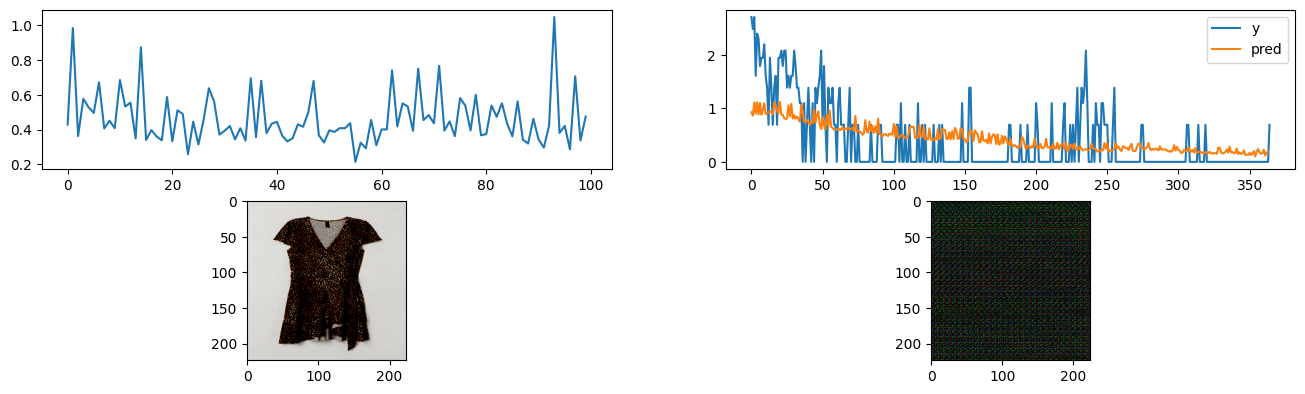

0 - loss: 0.45840521320700645, color_loss: 1.9660922420024871, lr: 0.001:  31%|███▏      | 528/1678 [01:05<02:22,  8.07it/s]


KeyboardInterrupt: 

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
mse_loss = torch.nn.MSELoss(reduction="none")
ce_loss = torch.nn.CrossEntropyLoss(reduction="none")

def loss_fn(pred, y, mask=None, padding_mask=None):
    loss = mse_loss(pred, y)

    # Masking mask
    if mask is not None:
        rows = torch.arange(loss.shape[0]).unsqueeze(1).to(torch.int)
        cols = mask.to(torch.int)
        loss[rows, cols] = 0

    # Padding mask
    padding_mask = torch.tensor([0]).to(device)
    if padding_mask is not None:
        loss = torch.where(padding_mask==1, 0, loss)

    num_valid_val = 1
    if mask is not None:
        num_valid_val = pred.reshape(-1).shape[0] - mask.reshape(-1).shape[0] + torch.where(padding_mask==0, 1, 0).sum()
    loss = loss.sum()/num_valid_val
    return loss

def ce_loss_fn(pred, y, mask, idx):
    loss = ce_loss(pred, y)
    mask = torch.where(mask==idx, 1, 0).sum(dim=-1)
    loss *= mask
    # loss = loss.sum()
    return loss

def train(e):
    pbar = tqdm(train_dataloader)
    loss_li, color_loss_li, window = [], [], 100

    for n, data in enumerate(pbar):
        model.train()
        optimizer.zero_grad()
        sales_output, day_output, dow_output, month_output, holiday_output, price_output, index_output, color_output, graphic_output, prod_output, img_output,\
            temp_keep_mask, static_idx_keep, img_idx_keep\
            = model(data["sales"].to(device),
                data["day"].to(device), data["dow"].to(device), data["month"].to(device), data["holiday"].to(device), data["price"].to(device),
                data["index"].to(device),  data["color"].to(device),  data["graphic"].to(device),  data["prod"].to(device),
                data["img_input"].to(device),
                data["sales_idx_keep"].to(device), data["sales_revert"].to(device),
                data["day_idx_keep"].to(device), data["day_revert"].to(device),
                data["dow_idx_keep"].to(device), data["dow_revert"].to(device),
                data["month_idx_keep"].to(device), data["month_revert"].to(device),
                data["holiday_idx_keep"].to(device), data["holiday_revert"].to(device),
                data["price_idx_keep"].to(device), data["price_revert"].to(device),
                data["temp_keep_padding_mask"].to(device), data["temp_revert_padding_mask"].to(device))
        
        sales_loss = loss_fn(sales_output[:, 1:], data["sales"].to(device), data["sales_idx_keep"].to(device), data["temp_revert_padding_mask"].to(device))
        img_loss = loss_fn(img_output[:, 1:], patchify(data["img_input"].to(device)), img_idx_keep)
        index_loss = ce_loss_fn(index_output, data["index"].squeeze().to(torch.long).to(device), static_idx_keep, 0)
        color_loss = ce_loss_fn(color_output, data["color"].squeeze().to(torch.long).to(device), static_idx_keep, 1)
        graphic_loss = ce_loss_fn(graphic_output, data["graphic"].squeeze().to(torch.long).to(device), static_idx_keep, 2)
        prod_loss = ce_loss_fn(prod_output, data["prod"].squeeze().to(torch.long).to(device), static_idx_keep, 3)

        static_loss = (index_loss + color_loss + graphic_loss + prod_loss).sum() / static_idx_keep.reshape(-1).shape[0]

        loss = sales_loss# + img_loss + static_loss

        loss.backward()
        optimizer.step()

        loss_li.append(loss.item())
        color_loss_li.append(color_loss.mean().item())
        pbar.set_description(f"{e} - loss: {np.mean(loss_li[-window:])}, color_loss: {np.mean(color_loss_li[-window:])}, lr: {optimizer.param_groups[0]['lr']}")
        if n %20 == 0:
            idx = 0
            plt.figure(figsize=(25,12))
            nrows, ncols = 5, 3
            clear_output(wait=True)

            # Loss
            plt.subplot(nrows, ncols, 1)
            plt.plot(loss_li[-window:])

            # Sample
            plt.subplot(nrows, ncols, 2)
            valid_len = data["temp_revert_padding_mask"].max(dim=-1).indices[idx]
            valid_len = data["sales"].shape[-1] if valid_len == 0 else valid_len
            plt.plot(data["sales"][idx][:valid_len], label="y")
            plt.plot(sales_output[idx][1:valid_len].detach().cpu(), label="pred")
            plt.legend()

            # Img
            plt.subplot(nrows, ncols, 4)
            img_input = data["img_input"]
            img_input = img_input.permute(0,2,3,1)
            img_input = img_input.cpu().detach().numpy()
            plt.imshow(img_input[idx])

            plt.subplot(nrows, ncols, 5)
            img_output = unpatchify(img_output[:, 1:]).permute(0,2,3,1)
            img_output = img_output.cpu().detach().numpy()
            plt.imshow(img_output[idx])

            index_output = torch.argmax(index_output, dim=-1).detach().cpu().numpy()
            index_output = train_dataset.get_encoder_dict()["index_encoder"].inverse_transform(index_output[idx])
            index_y = train_dataset.get_encoder_dict()["index_encoder"].inverse_transform(data["index"][idx].numpy()[0])
            print(f"y: {index_y}, pred: {index_output}")

            color_output = torch.argmax(color_output, dim=-1).detach().cpu().numpy()
            color_output = train_dataset.get_encoder_dict()["color_encoder"].inverse_transform(color_output[idx])
            color_y = train_dataset.get_encoder_dict()["color_encoder"].inverse_transform(data["color"][idx].numpy()[0])
            print(f"y: {color_y}, pred: {color_output}")

            graphic_output = torch.argmax(graphic_output, dim=-1).detach().cpu().numpy()
            graphic_output = train_dataset.get_encoder_dict()["graphic_encoder"].inverse_transform(graphic_output[idx])
            graphic_y = train_dataset.get_encoder_dict()["graphic_encoder"].inverse_transform(data["graphic"][idx].numpy()[0])
            print(f"y: {graphic_y}, pred: {graphic_output}")

            prod_output = torch.argmax(prod_output, dim=-1).detach().cpu().numpy()
            prod_output = train_dataset.get_encoder_dict()["prod_encoder"].inverse_transform(prod_output[idx])
            prod_y = train_dataset.get_encoder_dict()["prod_encoder"].inverse_transform(data["prod"][idx].numpy()[0])
            print(f"y: {prod_y}, pred: {prod_output}")

            plt.show()

epoch = 5
for e in range(epoch):
    train(e)
    scheduler.step()

# Eval

In [ ]:
model.eval()
pbar = tqdm(valid_dataloader)

for n, data in enumerate(pbar):
    with torch.no_grad():
        sales_output, day_output, dow_output, month_output, holiday_output, price_output, index_output, color_output, graphic_output, prod_output, img_output,\
            temp_keep_mask, static_idx_keep, img_idx_keep\
            = model(data["sales"].to(device),
                data["day"].to(device), data["dow"].to(device), data["month"].to(device), data["holiday"].to(device), data["price"].to(device),
                data["index"].to(device),  data["color"].to(device),  data["graphic"].to(device),  data["prod"].to(device),
                data["img_input"].to(device),
                data["sales_idx_keep"].to(device), data["sales_revert"].to(device),
                data["day_idx_keep"].to(device), data["day_revert"].to(device),
                data["dow_idx_keep"].to(device), data["dow_revert"].to(device),
                data["month_idx_keep"].to(device), data["month_revert"].to(device),
                data["holiday_idx_keep"].to(device), data["holiday_revert"].to(device),
                data["price_idx_keep"].to(device), data["price_revert"].to(device),
                data["temp_keep_padding_mask"].to(device), data["temp_revert_padding_mask"].to(device))

        if n %20 == 0:
            idx = 0
            plt.figure(figsize=(25,12))
            nrows, ncols = 5, 3
            clear_output(wait=True)
            
            # Sample
            plt.subplot(nrows, ncols, 2)
            valid_len = data["temp_revert_padding_mask"].max(dim=-1).indices[idx]
            valid_len = data["sales"].shape[-1] if valid_len == 0 else valid_len
            plt.plot(data["sales"][idx][:valid_len], label="y")
            plt.plot(sales_output[idx][1:valid_len].detach().cpu(), label="pred")
            plt.legend()

            # Img
            plt.subplot(nrows, ncols, 4)
            img_input = data["img_input"]
            img_input = img_input.permute(0,2,3,1)
            img_input = img_input.cpu().detach().numpy()
            plt.imshow(img_input[idx])

            plt.subplot(nrows, ncols, 5)
            img_output = unpatchify(img_output[:, 1:]).permute(0,2,3,1)
            img_output = img_output.cpu().detach().numpy()
            plt.imshow(img_output[idx])

            index_output = torch.argmax(index_output, dim=-1).detach().cpu().numpy()
            index_output = train_dataset.get_encoder_dict()["index_encoder"].inverse_transform(index_output[idx])
            index_y = train_dataset.get_encoder_dict()["index_encoder"].inverse_transform(data["index"][idx].numpy()[0])
            print(f"y: {index_y}, pred: {index_output}")

            color_output = torch.argmax(color_output, dim=-1).detach().cpu().numpy()
            color_output = train_dataset.get_encoder_dict()["color_encoder"].inverse_transform(color_output[idx])
            color_y = train_dataset.get_encoder_dict()["color_encoder"].inverse_transform(data["color"][idx].numpy()[0])
            print(f"y: {color_y}, pred: {color_output}")

            graphic_output = torch.argmax(graphic_output, dim=-1).detach().cpu().numpy()
            graphic_output = train_dataset.get_encoder_dict()["graphic_encoder"].inverse_transform(graphic_output[idx])
            graphic_y = train_dataset.get_encoder_dict()["graphic_encoder"].inverse_transform(data["graphic"][idx].numpy()[0])
            print(f"y: {graphic_y}, pred: {graphic_output}")

            prod_output = torch.argmax(prod_output, dim=-1).detach().cpu().numpy()
            prod_output = train_dataset.get_encoder_dict()["prod_encoder"].inverse_transform(prod_output[idx])
            prod_y = train_dataset.get_encoder_dict()["prod_encoder"].inverse_transform(data["prod"][idx].numpy()[0])
            print(f"y: {prod_y}, pred: {prod_output}")

            plt.show()
            input()

  0%|          | 0/839 [00:02<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.96 GiB (GPU 0; 23.67 GiB total capacity; 20.77 GiB already allocated; 1.40 GiB free; 21.87 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF